In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


np.random.seed(3116)
random.seed(3116)

In [2]:
bank=pd.read_csv('bank.csv', delimiter=';')

In [3]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
#Convert any non-numeric values to numeric values.

#Get dummies for variables with many unique values
bank=pd.get_dummies(bank, columns=['job', 'education', 'poutcome'])

#Turn into numbers data with other names
bank['month']=bank['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],[1,2,3,4,5,6,7,8,9,10,11,12])

#Replace values by -1,0,1 for columns with 3 unique values
bank['marital']=bank['marital'].replace(['married', 'single', 'divorced'],[-1,0,1])
bank['contact']=bank['contact'].replace(['cellular', 'unknown', 'telephone'],[-1,0,1])

#Replace values by 0,1 for columns with 2 unique values
bank['default']=bank['default'].replace(['no', 'yes'],[0,1])
bank['housing']=bank['housing'].replace(['no', 'yes'],[0,1])
bank['loan']=bank['loan'].replace(['no', 'yes'],[0,1])
bank['y']=bank['y'].replace(['no', 'yes'],[0,1])


In [5]:
bank.head()

,age,marital,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,-1,0,1787,0,0,-1,19,10,79,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
1,33,-1,0,4789,1,1,-1,11,5,220,1,339,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
2,35,0,0,1350,1,0,-1,16,4,185,1,330,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,30,-1,0,1476,1,1,0,3,6,199,4,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,59,-1,0,0,1,0,0,5,5,226,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [6]:
#Drop out the rows with missing values or NA.

bank=bank.dropna()

In [7]:
#Split the data into a train/test splits according to the ratios 80%:20%.

n=list(range(len(bank)))#Get indexes of bank
random.shuffle(n) #Shuffle the order 

limit=round(len(n)/100*80)
train=n[:limit] #Get first 80% indexes for training
test=n[limit:] #Get 20% indexes left for testing

bank_train=bank.iloc[train] #Distribute dataset
bank_test=bank.iloc[test] #Distribute dataset

In [8]:
#Normalize (Standardize) the data

bank_train=(bank_train-bank_train.mean())/bank_train.std()
bank_test=(bank_test-bank_train.mean())/bank_train.std()

y_train=bank_train['y'].to_numpy()
y_test=bank_test['y'].to_numpy()

bank_train.drop('y',axis=1,inplace=True)
bank_test.drop('y',axis=1,inplace=True)


x_train=bank_train.to_numpy()
x_test=bank_test.to_numpy()

In [9]:
#Implement logistic regression and mini-batch Gradient Ascent.

def logistic_regression(x,beta):
  return np.e**(x@beta)/(1+np.e**(x@beta))

def log_likelihood(x,y,beta):
  return y*np.log(logistic_regression(x,beta))-(1-y)*np.log(1-logistic_regression(x,beta))

def log_likelihood_derivative(x,y,beta):
  return x.T@(logistic_regression(x,beta)-y)

def gradient_ascent(x,y,xtest,ytest,batchsize,imax,mu,eps):
  beta=np.zeros(len(x[0])) #Initialize beta
  process=[]
  likelihood=[]
  n=len(x)//batchsize

  for i in range(imax):
    #Create batches
    for j in range(n+1):
      xbatch=x[j*batchsize:(j+1)*batchsize,:] #Choose elements that should be in this batch for x
      ybatch=y[j*batchsize:(j+1)*batchsize] #Choose elements that should be in this batch for y

      #Calculate step with batch
      nextstep=beta+mu*log_likelihood_derivative(xbatch,ybatch,beta) #Calculate next step
      
      next_mean=log_likelihood(x,y,nextstep).mean() #Get log likelihood for next step Deberia ser mayor
      beta_mean=log_likelihood(x,y,beta).mean() #Get log likelihood for previous step

      process.append(next_mean-beta_mean)
      likelihood.append(next_mean)
      beta=nextstep
      
    if next_mean-beta_mean<eps: #Compare difference to eps to check if algorithm should end
      return nextstep, process, likelihood

      
  return 'No convergence', process, likelihood



Initial likelyhood on test set was 0.5459300802640311
Resulting likelyhood on test set is -10.2482193859422


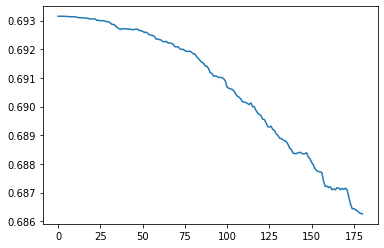

In [10]:
a,b,c=gradient_ascent(x_train,y_train,x_test,y_test,20,1000,0.0001,0.0000001)

print(f'Initial likelyhood on test set was {log_likelihood(x_test,y_test,np.zeros(len(x_test[0]))).mean()}')
print(f'Resulting likelyhood on test set is {log_likelihood(x_test,y_test,a).mean()}')

plt.plot(c) #Shows -log likelihood decreasing

In [17]:
#Keep the hyperparameters of learning rate and batch size fixed (good guesses) and iteratively do backward selection keeping track of the AIC metric.

#Implement logistic regression and mini-batch Gradient Ascent.

def logistic_regression(x,beta):
  return np.e**(x@beta)/(1+np.e**(x@beta))

def log_likelihood(x,y,beta):
  return -y*np.log(logistic_regression(x,beta))-(1-y)*np.log(1-logistic_regression(x,beta))

def log_likelihood_derivative(x,y,beta):
  return x.T@(y-np.e**(x@beta)/(1+np.e**(x@beta)))

def gradient_ascent(x,y,xtest,ytest,batchsize,imax,mu,eps):
  beta=np.zeros(len(x[0])) #Initialize beta
  process=[]
  likelihood=[]
  n=len(x)//batchsize
  
  for i in range(imax):
    #Create batches
    for j in range(n+1):
      xbatch=x[j*batchsize:(j+1)*batchsize,:] #Choose elements that should be in this batch for x
      ybatch=y[j*batchsize:(j+1)*batchsize] #Choose elements that should be in this batch for y

      #Calculate step with batch
      nextstep=beta+mu*log_likelihood_derivative(xbatch,ybatch,beta) #Calculate next step
      
      next_mean=log_likelihood(x,y,nextstep).mean() #Get log likelihood for next step Deberia ser mayor
      beta_mean=log_likelihood(x,y,beta).mean() #Get log likelihood for previous step

      process.append(next_mean-beta_mean)
      likelihood.append(next_mean)
      beta=nextstep
      
    if next_mean-beta_mean<eps: #Compare difference to eps to check if algorithm should end
      return nextstep, process, likelihood

      
  return 'No convergence', process, likelihood


def AIC(x,y,beta,p):
  return -2*np.log(log_likelihood(x,y,beta))+2*p

#Adapt to logistic regression
def backwardsearch(xtrain,ytrain,xtest,ytest):
  vused=[x for x in range(len(xtrain[0]))]
  vused=np.array(vused)
  improvement=True
  coefs1=0
  coefs2=0
  while improvement:
    bestgain=0
    for v in vused:
      #Choose variables
      idx=np.where(vused==v)
      vusednow=np.delete(vused,idx)
      trainwithout=xtrain[:,vusednow.astype(int)]
      testwithout=xtest[:,vusednow.astype(int)]

      coefs1,b,c=gradient_ascent(xtrain[:,vusednow.astype(int)],ytrain,xtest[:,vusednow.astype(int)],ytest,20,1000,0.00001,0.00001) 
      eval1=AIC(xtest[:,vusednow.astype(int)],ytest,coefs1,len(xtest[:,vusednow.astype(int)][0]))
      eval1=eval1[np.isfinite(eval1)].mean() #Minimize, should be smaller

      coefs2,b,c=gradient_ascent(xtrain[:,vused.astype(int)],ytrain,xtest[:,vused.astype(int)],ytest,20,1000,0.00001,0.00001)
      eval2=AIC(xtest[:,vused.astype(int)],ytest,coefs2,len(xtest[:,vused.astype(int)][0]))
      eval2=eval2[np.isfinite(eval2)].mean()

      #I'm possibly evaluating the wrong data

      evaltrain=AIC(xtrain[:,vused.astype(int)],ytrain,coefs2,len(xtrain[:,vused.astype(int)][0])).mean()
      gain=eval2-eval1
      if gain>bestgain:
        bestgain=gain
        bestv=v
    improvement=bestgain>0
    if improvement:
      idx=np.where(vused==bestv)
      vused=np.delete(vused,idx)
    print(f'The variables used are {vused}')
    print(f'The loss on training set is {evaltrain}')
    print(f'The loss on test set is {eval2}')
    print('----------------------------------------------') #Trouble on next iteration
  return vused

In [18]:
#Report the final error on Test set

vs=backwardsearch(x_train,y_train,x_test,y_test)

The variables used are [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
The loss on training set is 66.77503742642662
The loss on test set is 65.68037449775487
----------------------------------------------
The variables used are [ 0  1  2  3  4  5  6  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32]
The loss on training set is 64.77498526350045
The loss on test set is 63.67659605205536
----------------------------------------------
The variables used are [ 0  1  2  3  4  5  6  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
The loss on training set is 62.77450939674016
The loss on test set is 61.67405889016375
----------------------------------------------
The variables used are [ 0  1  2  3  5  6  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31]
The loss on training set is 60.770823905101274
The loss on test set is 59.671853954402465
-----------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


The variables used are [0 3 8 9]
The loss on training set is 10.752460452502712
The loss on test set is 9.669042458016825
----------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


The variables used are [0 3 9]
The loss on training set is nan
The loss on test set is 1.040824634671342
----------------------------------------------
The variables used are [3 9]
The loss on training set is nan
The loss on test set is -0.9455435025795715
----------------------------------------------
The variables used are [9]
The loss on training set is nan
The loss on test set is -2.8107368295750503
----------------------------------------------
The variables used are [9]
The loss on training set is nan
The loss on test set is -4.4030165097958305
----------------------------------------------


In [19]:
#Pick a range of α0 and λ defined on grid. You can choose fixed batchsize = 50.
batchsize=50
alpha=10**np.linspace(-10,0,20)
lambdas=10**np.linspace(-10,0,20)

aa, ll=np.meshgrid(alpha,lambdas)

In [20]:
#Implement k-fold cross-validation protocol for grid search. 
#For each combination of α0 and λ you will perform k-fold cross-validation. Let k = 5 in this case.

def class_accuracy(x,y,beta): #Create accuracy function for evaluation
  yhat=1/(1+np.e**(-x@beta))
  corrects=0
  for i in range(len(y)):
    if y[i]<0.5 and yhat[i]<0.5:
      corrects=corrects+1
    elif y[i]>0.5 and yhat[i]>0.5:
      corrects=corrects+1

  return corrects/len(y)

def l(x,y,beta,lamb):
  return y@(x@beta)-np.log(1+np.e**(x@beta))+lamb*(beta.T@beta)

def gridsearch(x,y,tmax,eps,k):
  bestloss=[]
  bestlambda=[]
  bestalpha=[]
  bestbeta=[]
  batchsize=len(x)//k
  beta = np.zeros(len(x[0]))
  accuracy=[]
  for i in range(len(aa)):
    for j in range(len(aa[0])):
      alpha=aa[i,j] #Get alpha
      lamb=ll[i,j] #Get lambda

      loss=l(x,y,beta,lamb).mean()
      for h in range(k):
        xbatch=x[h*batchsize:(h+1)*batchsize,:] #Choose elements that should be in this batch for x
        ybatch=y[h*batchsize:(h+1)*batchsize] #Choose elements that should be in this batch for y

        for t in range(tmax):
          yhat=1/(1+np.e**(-xbatch@beta))
          beta=beta+alpha*(1/len(xbatch)*xbatch.T@(ybatch-yhat))-2*lamb*(beta.T@beta) #Get next step

          loss_old=loss
          loss=l(xbatch,ybatch,beta,lamb).mean() #Calculate loss

        if loss-loss_old<eps: #Check if there is convergence
          #Save variables
          bestloss.append(loss)
          bestlambda.append(lamb)
          bestalpha.append(alpha)
          accuracy.append(class_accuracy(x,y,beta))
          break

  return bestloss, bestlambda, bestalpha, accuracy



In [21]:
loss, lamb, alpha, accuracy=gridsearch(x_train,y_train,500,0.01,5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in power
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in matmul
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in matmul
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: inval

In [22]:
#Get best hyperparameters
loss, lamb, alpha, accuracy=np.array(loss), np.array(lamb), np.array(alpha), np.array(accuracy)
bestlamba=lamb[loss==loss.min()]
bestalpha=alpha[loss==loss.min()]
bestaccuracy=accuracy[loss==loss.min()]


print('best lambda is '+str(bestlamba))
print('best alpha is '+str(bestalpha))
print('best accuracy is '+str(bestaccuracy))

best lambda is [1.e-10]
best alpha is [1.e-10]
best accuracy is [0.71633951]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Attempting to set identical left == right == 1e-10 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.


Text(0.5, 0, 'accuracy')

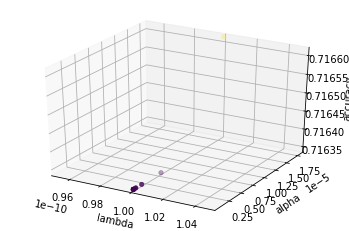

In [23]:
#Plot accuracies
ax = plt.axes(projection='3d')
ax.scatter(lamb, alpha, accuracy, c=accuracy, cmap='viridis', linewidth=0.5)
ax.set_xlim([lamb.min(), lamb.max()])
ax.set_ylim([alpha.min(), alpha.max()])
ax.set_zlim([accuracy.min(), accuracy.max()])

ax.set_xlabel('lambda')
ax.set_ylabel('alpha')
ax.set_zlabel('accuracy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Attempting to set identical left == right == 1e-10 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.


Text(0.5, 0, 'loss')

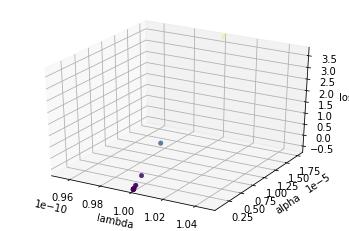

In [24]:
#Plot losses
ax = plt.axes(projection='3d')
ax.scatter(lamb, alpha, loss, c=loss, cmap='viridis', linewidth=0.5)
ax.set_xlim([lamb.min(), lamb.max()])
ax.set_ylim([alpha.min(), alpha.max()])
ax.set_zlim([loss.min(), loss.max()])

ax.set_xlabel('lambda')
ax.set_ylabel('alpha')
ax.set_zlabel('loss')